## Import libraries

In [1]:
import quail
import numpy as np
import pandas as pd
from os.path import join as opj
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Settings and parameters

In [2]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'
sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
cmap = plt.cm.bone_r

## Load data

In [3]:
video_events = np.load(opj(datadir, 'video_events.npy'), allow_pickle=True)
recall_events = np.load(opj(datadir, 'recall_events.npy'), allow_pickle=True)

ks = [r.shape[0] for r in recall_events]
hand_rec = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])

## Define some functions

In [4]:
def _r2z(r):
    """
    Function that calculates the Fisher z-transformation

    Parameters
    ----------
    r : int or ndarray
        Correlation value

    Returns
    ----------
    result : int or ndarray
        Fishers z transformed correlation value

    """
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    
def precision_func(video, recall):
    return np.max(1 - cdist(video, recall, 'correlation'), 0).mean()


def distinctiveness_func(video, recall):
    corrmat = 1 - cdist(video, recall, 'correlation')
    return 1 - np.mean([np.sort(r_ev)[:-1].mean() for r_ev in corrmat.T])


def corr_pearsonr(r_vals, metric2):
    return pearsonr(_r2z(np.array(r_vals)), metric2)


def fmt_stat(stat):
    r, p = stat
    if p < .01:
        return f"$r = {round(r, 2)}$\n$p < .01$"
    else:
        return f"$r = {round(r, 2)}$\n$p = {round(p, 2)}$"

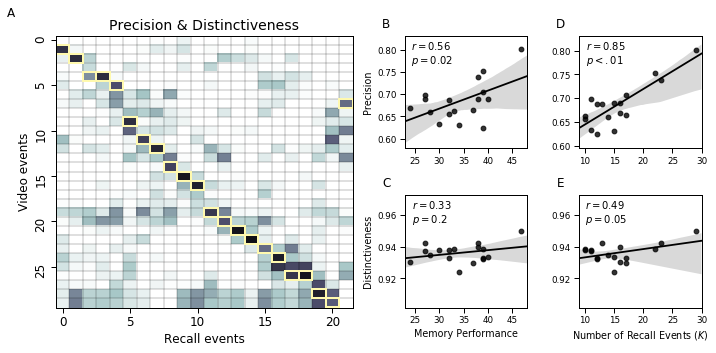

In [5]:
# general settings and 
fig = plt.figure()
fig.set_size_inches(10, 5)
gs = fig.add_gridspec(2, 4)

a = fig.add_subplot(gs[0:, :-2])
b = fig.add_subplot(gs[0, 2])
c = fig.add_subplot(gs[1, 2])
d = fig.add_subplot(gs[0, 3])
e = fig.add_subplot(gs[1, 3])

# format the data
precision = [precision_func(video_events, r) for r in recall_events]
distinctiveness = [distinctiveness_func(video_events, r) for r in recall_events]

df = pd.DataFrame(np.array([hand_rec, ks, precision, distinctiveness]).T, 
                  columns=['Memory Performance', 'Number of Recall Events ($K$)', 
                           'Precision', 'Distinctiveness'])

# precision schematic
data = 1 - cdist(video_events, recall_events[16], 'correlation')
g1 = sns.heatmap(data, cmap=cmap, xticklabels=5, yticklabels=5, 
                 vmin=0, vmax=1, ax=a, cbar=False)
g1.set_title('Precision & Distinctiveness', fontsize=14)
g1.set_ylabel('Video events', fontsize=12)
g1.set_xlabel('Recall events', fontsize=12)
g1.tick_params('both', labelsize=12)
for _, spine in g1.spines.items():
    spine.set_visible(True)
g1.hlines(list(range(video_events.shape[0])), *g1.get_xlim(), linewidth=.25)
g1.vlines(list(range(recall_events[16].shape[0])), *g1.get_ylim(), linewidth=.25)
bounds = np.argmax(data, axis=0)
for i in range(len(bounds)):
    rect = patches.Rectangle((i, bounds[i]), 1, 1, linewidth=2, edgecolor='#FFF9AE', 
                             facecolor='none', zorder=2, alpha=1)
    g1.add_patch(rect)
    
# correlation plots
sns.regplot(df['Memory Performance'], df['Precision'], ax=b, color='black')
sns.regplot(df['Memory Performance'], df['Distinctiveness'], ax=c, color='black')
sns.regplot(df['Number of Recall Events ($K$)'], df['Precision'], ax=d, color='black')
sns.regplot(df['Number of Recall Events ($K$)'], df['Distinctiveness'], ax=e, color='black')

# add labels
label=['A', 'B', 'C', 'D', 'E']
for p, l in zip([a, b, c, d, e], label):
    p.text(-.15,1.07,l,
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=12)

# format axes
b.set(xticks=np.arange(25, 50, 5), xlabel=None)
c.set(xticks=np.arange(25, 50, 5))
d.set(xticks=np.arange(10, 35, 5), xlabel=None, ylabel=None)
e.set(xticks=np.arange(10, 35, 5), ylabel=None)
    
# add stats
cols = [('Precision', 'Memory Performance'), 
        ('Distinctiveness', 'Memory Performance'),
        ('Precision', 'Number of Recall Events ($K$)'),
        ('Distinctiveness', 'Number of Recall Events ($K$)')]
for p, c in zip([b, c, d, e], cols):
    stat = corr_pearsonr(df[c[0]], df[c[1]])
    p.text(.22, .75, fmt_stat(stat),
           horizontalalignment='center', 
           multialignment='left',
           transform=p.transAxes,
           fontsize=10)

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.tight_layout()

# plt.savefig(opj(figdir, 'precision_distinctiveness.pdf'))